# Compare decay calculation results of radioactivedecay and PyNE
This notebook compares decay calculation results between the Python package [radioactivedecay](https://pypi.org/project/radioactivedecay/) `v0.0.8` and [PyNE](https://pyne.io/) `v0.7.2`. The PyNE decay data is read in by radioactivedecay, so both codes are using the same underlying decay data for the calculations.

Note the following radionuclides were removed from the decay dataset fed to radioactivedecay, as these radionuclides are part of chains where two radionuclides have degenerate half-lives: Po-191, Pt-183, Bi-191, Pb-187, Tl-187, Rn-195, At-195, Hg-183, Au-183, Pb-180, Hg-176, Tl-177, Pt-172, Ir-172, Lu-153 and Ta-157. radioactivedecay cannot calculate decays for chains containing radionuclides with identical half-lives, and the PyNE treatment for these chains currently suffers from a [bug](https://github.com/pyne/pyne/issues/1342).

First import the necessary modules for the comparison.

In [1]:
import radioactivedecay as rd
import pyne
from pyne import nucname, data
from pyne.material import Material, from_activity
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

print("Package versions used: radioactivedecay", rd.__version__, "PyNE", pyne.__version__)

Package versions used: radioactivedecay 0.0.8 PyNE 0.7.1


### Load PyNE decay dataset into radioactivedecay, check a simple case

Load the decay dataset created using the PyNE data into radioactivedecay.

In [2]:
pynedata = rd.DecayData(dataset="pyne_truncated", dir_path=".")

Define some functions to perform radioactive decay calculations for a single radionuclide with radioactivedecay and PyNE. To compare the results we have to remove the stable radionuclides from the inventory returned by PyNE. We also have to convert the canonical radionuclide ids into string format (e.g. `10030000` to `H-3`), and sort the inventory alphabetically.

In [3]:
def rd_decay(nuclide, time):
    """Perform a decay calculation for one radionuclide with radioactivedecay."""

    return rd.Inventory({nuclide: 1.0}, data=pynedata).decay(time).contents

def add_hyphen(name):
    """Add a hypen to radionuclide name string e.g. H3 to H-3."""

    for i in range(1, len(name)):    
        if not name[i].isdigit(): continue
        name = name[:i] + "-" + name[i:]
        break
    return name

def strip_stable(inv):
    """Remove stable nuclides from a PyNE inventory."""

    new_inv = dict()
    for id in inv:
        if data.decay_const(id) <= 0.0: continue
        new_inv[add_hyphen(nucname.name(id))] = inv[id]
    return new_inv

def pyne_decay(nuclide, time):
    """Perform a decay calculation for one radionuclide with PyNE."""

    inv = strip_stable(from_activity({nucname.id(nuclide): 1.0}).decay(time).activity())
    return dict(sorted(inv.items(), key=lambda x: x[0]))

First let's compare the decay results for a single case - the decay of 1 unit (Bq or Ci) of Pb-212 for 0.0 seconds:

In [4]:
inv_rd = rd_decay("Pb-212", 0.0)
inv_pyne = pyne_decay("Pb-212", 0.0)
print(inv_rd)
print(inv_pyne)

{'Bi-212': 0.0, 'Pb-212': 1.0, 'Po-212': 0.0, 'Tl-208': 0.0}
{'Pb-212': 1.0000000000000002, 'Tl-208': 9.068518400455239e-17}


radioactivedecay returns activities for all the radionuclides in the decay chain below Pb-212, even though they have zero activity. PyNE does not return activities for two of the radionuclides (Bi-212 and Po-212), presumably because it evaluated their activities to be exactly zero. A small non-zero activity is returned for Ti-208, and the activity of Pb-212 deviates slightly from unity. The likely explanation for these results is round-off errors.

For the below comparisons, it makes sense to compare the activities of the radionuclides returned by both radioactivedecay and PyNE, whilst checking the activities of the radionuclides missing from the inventories returned by either radioactivedecay or PyNE are negligible. This function cuts down the inventories returned by radioactivedecay and PyNE to just the radionuclides present in both inventories. It also reports how many radionuclides were removed from each inventory to do this.

In [5]:
def match_inventories(inv1, inv2):
    """Cuts down the two inventories so they only contain the radionuclides present in both.
    Also returns inventories of the radionuclides unique to each inventory."""
    
    s1 = set(inv1.keys())
    s2 = set(inv2.keys())
    s = s1.intersection(s2)
    inv1_intersection = {nuclide: inv1[nuclide] for nuclide in s}
    inv2_intersection = {nuclide: inv2[nuclide] for nuclide in s}
    inv1_difference = {nuclide: inv1[nuclide] for nuclide in s1.difference(s2)}
    inv2_difference = {nuclide: inv2[nuclide] for nuclide in s2.difference(s1)}
    return inv1_intersection, inv1_difference, inv2_intersection, inv2_difference

### Generate decay calculation comparisons between radioactivedecay and PyNE

We now systematically compare the results of decay calculations performed using radioactivedecay and PyNE. The strategy is the set initial inventories containing 1 Bq of each radionuclide in the decay dataset, and then decay for various time periods that are factor multiples of that radionuclides half-life. The factor multiples used are zero and each order of magnitude between 10<sup>-6</sup> and 10<sup>6</sup>, inclusive.

We calculate the absolute activity error for each radionuclide returned by both radioactivedecay and PyNE in the decayed inventories, as well as the relative activity error to the PyNE activity. We store the results in a Pandas DataFrame. We also store the results for the radionuclides that are not returned in either the radioactivedecay or PyNE inventories for examination.

In [6]:
hl_factors = [0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
rows = []
rows_pyne_missing = []
rows_rd_missing = []

for hl_factor in hl_factors:
    for nuclide in pynedata.radionuclides:
        decay_time = hl_factor*rd.Radionuclide(nuclide, data=pynedata).half_life()
        rd_inv = rd_decay(nuclide, decay_time)
        pyne_inv = pyne_decay(nuclide, decay_time)
        rd_inv, rd_unique, pyne_inv, pyne_unique = match_inventories(rd_inv, pyne_inv)

        if len(rd_unique) != 0:
            for nuc, act in rd_unique.items():
                rows_pyne_missing.append({
                    "parent": nuclide,
                    "hl_factor": hl_factor,
                    "decay_time": decay_time,
                    "pyne_missing_nuclide": nuc,
                    "rd_activity": act
                })
        if len(pyne_unique) != 0:
            for nuc, act in pyne_unique.items():
                rows_rd_missing.append({
                    "parent": nuclide,
                    "hl_factor": hl_factor,
                    "decay_time": decay_time,
                    "rd_missing_nuclide": nuc,
                    "pyne_activity": act
                })

        for nuc, pyne_act in pyne_inv.items():
            rd_act = rd_inv[nuc]
            if pyne_act == 0.0:
                if rd_act == 0.0:
                    abs_err = 0.0
                    rel_err = 0.0
                else:
                    abs_err = abs(rd_act)
                    rel_err = np.inf
            else:
                abs_err = abs(pyne_act-rd_act)
                rel_err = abs_err/abs(pyne_act)
            
            rows.append({
                "parent": nuclide,
                "hl_factor": hl_factor,
                "decay_time": decay_time,
                "nuclide": nuc,
                "pyne_activity": pyne_act,
                "rd_activity": rd_act,
                "abs_err": abs_err,
                "rel_err": rel_err,
            })

df = pd.DataFrame(rows)
df_pyne_missing = pd.DataFrame(rows_pyne_missing)
df_rd_missing = pd.DataFrame(rows_rd_missing)

### Examine cases where radionuclides not returned by radioactivedecay and PyNE

First we check the cases where radionuclides returned by PyNE are not present in decayed inventory from radioactivedecay.

In [7]:
print("Radionuclides not returned by radioactivedecay:", df_rd_missing.rd_missing_nuclide.unique())
print("These cases arise from the decay chains of:", df_rd_missing.parent.unique())
print("Total number of missing cases:", len(df_rd_missing))

Radionuclides not returned by radioactivedecay: ['Be-8' 'Re-192' 'Ho-170' 'He-8' 'H-3' 'Li-8']
These cases arise from the decay chains of: ['He-10' 'Ta-192' 'Tb-170' 'H-6']
Total number of missing cases: 68


radioactivedecay does not return activities for these radionuclides as the chains all pass through radionuclides which PyNE reports as having an undefined half-life:

In [8]:
print(data.half_life("He-9"), data.half_life("W-192"), data.half_life("Dy-170"), data.half_life("H-5"))

nan nan nan nan


PyNE clearly has some assumption to infer the half-lives and simulate these decay chains.

Now we check the radionuclides not returned by PyNE:

In [9]:
print("Total number of missing cases:", len(df_pyne_missing))
df_pyne_missing.sort_values(by=["rd_activity"], ascending=False).head(n=10)

Total number of missing cases: 72319


,parent,hl_factor,decay_time,pyne_missing_nuclide,rd_activity
27879,Fr-229,0.000100,0.005020,Fr-225,2.408050e-14
33440,Po-219,0.001000,0.620000,Tl-207,9.620381e-16
15660,Tl-192,0.000001,0.000576,Au-192,4.602706e-16
28023,Po-219,0.000100,0.062000,Bi-211,3.183028e-16
23920,Sm-132,0.000010,0.000040,Pr-132,2.960595e-16
15148,Po-219,0.000001,0.000620,Tl-207,2.405095e-16
21718,Po-219,0.000010,0.006200,Bi-211,2.219744e-16
14955,Th-227,0.000001,1.615421,Tl-207,1.721057e-16
14931,Ra-228,0.000001,181.456200,Bi-212,1.193786e-16
14934,Ra-228,0.000001,181.456200,Pb-212,1.116637e-16


The maximum activity of any radionuclide returned by radioactivedecay but not returned by PyNE is 2.4E-14 Bq. The activities in all other cases are lower than this. This could be related to PyNE filtering out any results it considers negligible.

### Comparing decayed activities between radioactivedecay and PyNE

We now compare the decayed activities of radionuclides returned both by radioactivedecay and by PyNE. For the 237095 comparisons, the mean and maximum absolute errors are 1.9E-17 Bq and 5.8E-14 Bq, respectively:

In [10]:
df.describe()

,hl_factor,decay_time,pyne_activity,rd_activity,abs_err,rel_err
count,237095.000000,2.370950e+05,2.370950e+05,2.370950e+05,2.370950e+05,2.370950e+05
mean,61048.250216,1.148064e+30,9.653875e-02,9.653875e-02,1.925006e-17,inf
std,225951.144021,5.015659e+32,2.849834e-01,2.849834e-01,3.195269e-16,NaN
min,0.000000,0.000000e+00,0.000000e+00,-5.756296e-15,0.000000e+00,0.000000e+00
25%,0.001000,5.150000e-03,2.784710e-29,4.289621e-34,2.332961e-41,2.220448e-16
50%,1.000000,2.640000e+01,8.984094e-17,8.405931e-17,8.077936e-28,1.060557e-14
75%,1000.000000,1.188000e+05,1.634520e-06,1.634520e-06,6.776264e-21,3.101915e-04
max,1000000.000000,2.429935e+35,1.000000e+00,1.000000e+00,5.756296e-14,inf


In [11]:
df.sort_values(by=["abs_err", "rel_err", "pyne_activity"], ascending=False).head(n=10)

,parent,hl_factor,decay_time,nuclide,pyne_activity,rd_activity,abs_err,rel_err
81250,Ra-229,0.010000,2.400000,Fr-225,2.074326e-05,2.074326e-05,5.756296e-14,2.775020e-09
47195,Ra-229,0.000100,0.024000,Fr-225,2.088039e-09,2.087981e-09,5.756296e-14,2.756796e-05
63854,Ra-229,0.001000,0.240000,Fr-225,2.086748e-07,2.086747e-07,5.756296e-14,2.758501e-07
99522,Ra-229,0.100000,24.000000,Fr-225,1.954116e-03,1.954116e-03,5.756290e-14,2.945726e-11
63842,Fr-229,0.001000,0.050200,Fr-225,4.093686e-13,4.575296e-13,4.816101e-14,1.176471e-01
81358,Pa-227,0.010000,22.980000,Bi-211,6.043617e-03,6.043617e-03,3.863923e-14,6.393395e-12
16044,Pa-227,0.000001,0.002298,Bi-211,1.422683e-12,1.454475e-12,3.179190e-14,2.234643e-02
99507,Fr-229,0.100000,5.020000,Fr-225,4.294567e-07,4.294567e-07,2.408050e-14,5.607202e-08
118695,Fr-229,1.000000,50.200000,Fr-225,3.364478e-04,3.364478e-04,2.408040e-14,7.157247e-11
47297,Pa-227,0.000100,0.229800,Bi-211,5.138163e-07,5.138163e-07,2.384401e-14,4.640570e-08


For around 10% of the activities compared the activity calculated by radioactivedecay and PyNE are identical:

In [12]:
len(df[df.abs_err == 0.0])

22640

Now plot the errors. For cases where the PyNE activity is 0.0, we set these activity values to 10<sup>-70</sup> and the relative errors to 10<sup>17</sup> to force the points to show on the panel (a) log-log graph.

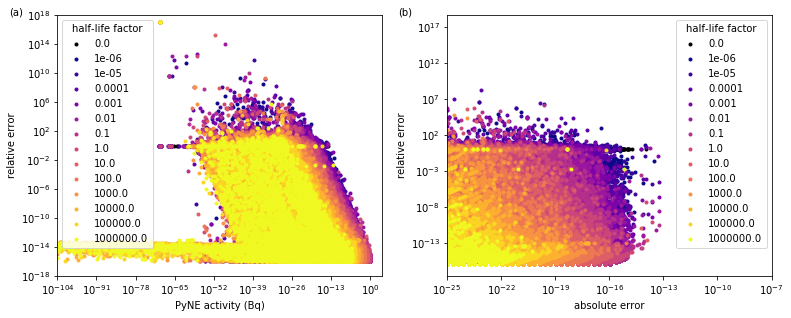

In [13]:
df.loc[(df["pyne_activity"] == 0.0) & (df["rd_activity"] != 0.0), "pyne_activity"] = 1e-70
df.loc[df["rel_err"] == np.inf, "rel_err"] = 1e17

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12.8,4.8))

cmap_colors = plt.get_cmap("plasma").colors
colors = ["black"]
n = len(hl_factors)-1
colors.extend([""] * n)
for i in range(0, n):
    colors[i+1] = cmap_colors[int(round((i*(len(cmap_colors)-1)/(n-1))))]

for i in range(0, len(hl_factors)):
    ax[0].plot(df[df.hl_factor == hl_factors[i]].pyne_activity, df[df.hl_factor == hl_factors[i]].rel_err,
               marker=".", linestyle="", label=hl_factors[i], color=colors[i])
ax[0].set(xlabel="PyNE activity (Bq)", ylabel="relative error", xscale="log", yscale="log")
ax[0].legend(loc="upper left", title="half-life factor")
ax[0].text(-0.15, 1.0, "(a)", transform=ax[0].transAxes)
ax[0].set_xlim(1e-104, 1e4)
ax[0].set_ylim(1e-18, 1e18)

for i in range(0, len(hl_factors)):
    ax[1].plot(df[df.hl_factor == hl_factors[i]].abs_err, df[df.hl_factor == hl_factors[i]].rel_err,
               marker=".", linestyle="", label=hl_factors[i], color=colors[i])
ax[1].set(xlabel="absolute error", ylabel="relative error", xscale="log", yscale="log")
ax[1].legend(loc="upper right", title="half-life factor")
ax[1].set_xlim(1e-25, 1e-7)
_ = ax[1].text(-0.15, 1.0, "(b)", transform=ax[1].transAxes)

In all cases the differences in activities reported by radioactivedecay and by PyNE are small (< 1E-13 Bq). Relative errors tend to increase as the radioactivity reported by PyNE decreases from 1 Bq. Relative errors greater than 1E-4 only occur when the PyNE activity is smaller than 2.5E-11.

In [14]:
df[df.rel_err > 1E-4].pyne_activity.max()

2.4516062878803175e-11

### Summary

The activity results reported by radioactivedecay and PyNE differ by less than 1E-13 Bq, given an initial inventory of 1 Bq of the parent radionuclide. Both radioactivedecay and PyNE use double precision floating point arithmetic. PyNE also uses some slightly different treatments than radioactivedecay for calculating decay chains passing through almost stable radionuclides, and for filtering out radionuclides with negligible activities.

In summary we can the results calculated by radioactivedecay and PyNE using the PyNE decay dataset are identical to within reasonable expectations for numerical precision.